In [12]:
import numpy as np
import cv2
import pickle
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def plotImages(rows, cols, imgs, titles, FileName, axis='on', figsize=(14, 10), cmap=''):
    fig = plt.figure(figsize=figsize)
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(titles[i])
        plt.axis(axis)
        if(cmap == 'gray'):
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
    plt.subplots_adjust(hspace=.5)
    plt.savefig('./Theoutput_images/'+FileName)
    plt.show()
    

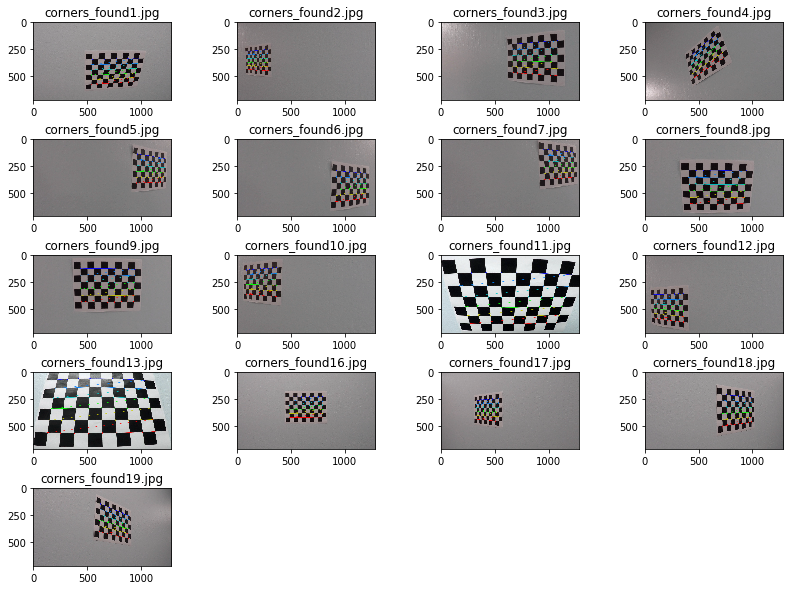

In [13]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#Hold Caliberated chessboard Image
ChessBoardImageArray = []
ChessBoardImageName = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img1 = cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        ChessBoardImageArray.append(img1)
        ChessBoardImageName.append('corners_found'+str(idx)+'.jpg')

cv2.destroyAllWindows()

plotImages(5, 4, ChessBoardImageArray, ChessBoardImageName, FileName='ChessboardUndistort.png')

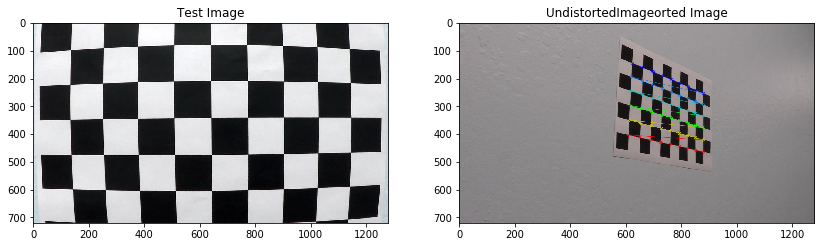

In [14]:
# Test UndistortedImageortion on an image
TestImage = cv2.imread('./camera_cal/calibration1.jpg')
ImageSize = (TestImage.shape[1], TestImage.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, ImageSize,None,None)
UndistortedImageortedImage = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./Theoutput_images/calibration.p", "wb" ) )

plotImages(1,2,(TestImage,UndistortedImageortedImage),("Test Image","UndistortedImageorted Image"), FileName='TestAndUndistort.png') 

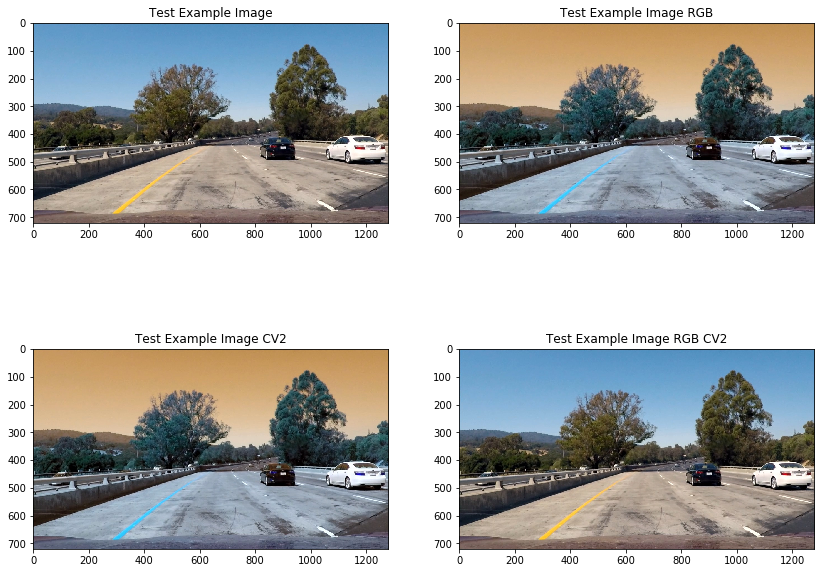

In [15]:
# Choose an image from which to build and demonstrate each step of the pipeline
TestExampleImageCV2 = cv2.imread('./test_images/test1.jpg')
TestExampleImage = mpimg.imread('./test_images/test1.jpg')
TestExampleImageRGBCV2 = cv2.cvtColor(TestExampleImageCV2, cv2.COLOR_BGR2RGB)
TestExampleImageRGB = cv2.cvtColor(TestExampleImage, cv2.COLOR_BGR2RGB)
plotImages(2,2,(TestExampleImage, TestExampleImageRGB, TestExampleImageCV2, TestExampleImageRGBCV2),
           ("Test Example Image", "Test Example Image RGB", "Test Example Image CV2", "Test Example Image RGB CV2"),
          FileName='RGBAndCV2.png') 

In [16]:
# UndistortedImageort image using camera calibration matrix derived in above steps
def CalculateUndistortedImageort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)
    UndistortedImage = cv2.undistort(img, mtx, dist, None, mtx)
    return UndistortedImage

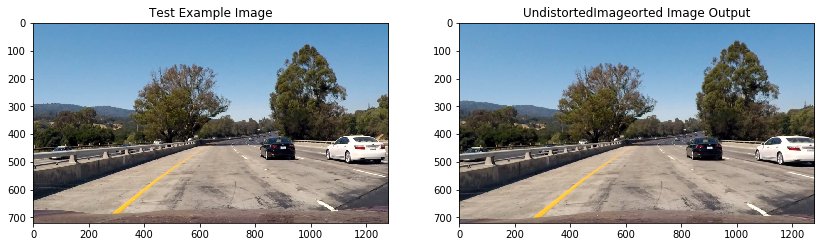

In [17]:
UndistortedImageortTestExampleImage = CalculateUndistortedImageort(TestExampleImage, objpoints, imgpoints)

plotImages(1,2,(TestExampleImage,UndistortedImageortTestExampleImage),
           ("Test Example Image","UndistortedImageorted Image Output"), FileName='UndistortTestImage.png') 


In [18]:
def AbsoluteSobelThreshold(img, orient='x', SobelKernel=3, Threshold=(0, 255)):
    # Apply the absolute Sobel filter. Sobel operator detects gradients in x and y directions.
    # Apply the following steps to img
    # 1) Convert to grayscale
    GrayscaleImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(GrayscaleImage, cv2.CV_64F, 1, 0, ksize=SobelKernel)
    elif orient == 'y':
        sobel = cv2.Sobel(GrayscaleImage, cv2.CV_64F, 0, 1, ksize=SobelKernel)
    else:
        raise ValueError('orient must be "x" or "y".')
    # 3) Take the absolute value of the derivative or gradient
    AbsoluteSobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    ScaledSobel = np.uint8(255 * AbsoluteSobel / np.max(AbsoluteSobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    SobelBinary = np.zeros_like(ScaledSobel)
    SobelBinary[(ScaledSobel >= Threshold[0]) & (ScaledSobel <= Threshold[1])] = 1
    # 6) Return this mask as final output image
    return SobelBinary
 

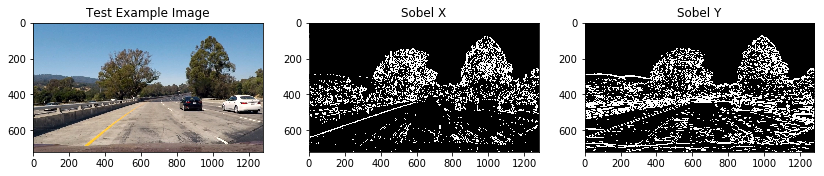

In [19]:
TestImage1 = mpimg.imread('./test_images/test1.jpg')
SobelX = AbsoluteSobelThreshold(TestImage1, 'x', SobelKernel=15, Threshold=(15, 100))
SobelY = AbsoluteSobelThreshold(TestImage1, 'y', SobelKernel=15, Threshold=(15, 100))

plotImages(1,3,(TestImage1, SobelX, SobelY),("Test Example Image", "Sobel X", "Sobel Y"), 
           cmap='gray', FileName='SobelXAndYImages.png') 

In [20]:
def MagnitudeOfGradient(img, SobelKernel=3, Threshold=(0, 255)):
    # Apply filter according to magnituide of gradient.
    # Apply the following steps to img
    # 1) Convert to grayscale
    GrayscaleImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    SobelX = cv2.Sobel(GrayscaleImage, cv2.CV_64F, 1, 0, ksize=SobelKernel)
    SobelY = cv2.Sobel(GrayscaleImage, cv2.CV_64F, 0, 1, ksize=SobelKernel)
    # 3) Calculate the magnitude 
    GradientMagnitude = np.sqrt(SobelX**2 + SobelY**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    ScaledGradientMagnitude = np.uint8(255 * GradientMagnitude / np.max(GradientMagnitude))
    # 5) Create a final binary mask where Magnitude thresholds are met
    FinalGradientMagnitude = np.zeros_like(ScaledGradientMagnitude)
    FinalGradientMagnitude[(ScaledGradientMagnitude >= Threshold[0]) & (ScaledGradientMagnitude <= Threshold[1])] = 1
    # 6) Return this mask as your output image
    return FinalGradientMagnitude
     

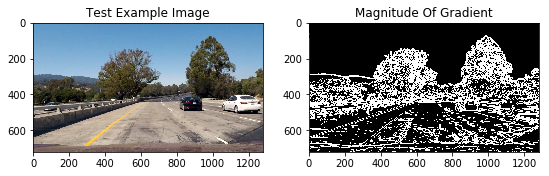

In [21]:
TestImage1 = mpimg.imread('./test_images/test1.jpg')
# magnitude of gradient filter
FinalMagnitudeOfGradient = MagnitudeOfGradient(TestImage1, SobelKernel=15, Threshold=(15, 100))
plotImages(1,3,(TestImage1, FinalMagnitudeOfGradient),("Test Example Image", "Magnitude Of Gradient"), 
           cmap='gray', FileName='MagnitudeOfGradient.png') 

In [22]:
def GradientDirectionMask(img, SobelKernel=3, Threshold=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    GrayscaleImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    SobelX = cv2.Sobel(GrayscaleImage, cv2.CV_64F, 1, 0, ksize=SobelKernel)
    SobelY = cv2.Sobel(GrayscaleImage, cv2.CV_64F, 0, 1, ksize=SobelKernel)
    # 3) Take the absolute value of the x and y gradients
    AbsoluteSobelX = np.absolute(SobelX)
    AbsoluteSobelY = np.absolute(SobelY)
    # 4) Use np.arctan2(AbsoluteSobelY, AbsoluteSobelX) to calculate the direction of the gradient 
    GradientDirection = np.arctan2(AbsoluteSobelY, AbsoluteSobelX)
    # 5) Create a binary mask where direction thresholds are met
    FinalGradientDirection = np.zeros_like(GradientDirection)
    FinalGradientDirection[(GradientDirection >= Threshold[0]) & (GradientDirection <= Threshold[1])] = 1
    # 6) Return this mask as your "FinalGradientDirection" image
    return FinalGradientDirection

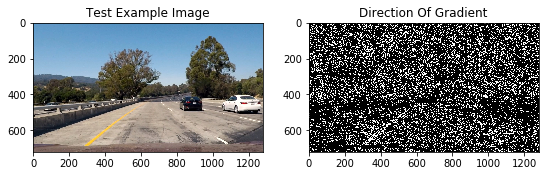

In [23]:
TestImage1 = mpimg.imread('./test_images/test1.jpg')
# direction of gradient filter
DirectionOfGradiantMask = GradientDirectionMask(TestImage1, SobelKernel=15, Threshold=(0.7, 1.1))
plotImages(1,3,(TestImage1, DirectionOfGradiantMask),("Test Example Image", "Direction Of Gradient"), 
           cmap='gray', FileName='GradientDirection.png') 

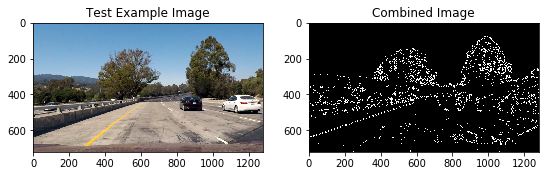

In [24]:
def ApplyGradientFilters(image):
    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    GradientX = AbsoluteSobelThreshold(image, 'x', SobelKernel=ksize, Threshold=(20, 100))
    GradientY = AbsoluteSobelThreshold(image, 'y', SobelKernel=ksize, Threshold=(20, 100))
    TheMagnitudeOfGradient = MagnitudeOfGradient(image, SobelKernel=ksize, Threshold=(30, 100))
    TheDirectionOfGradiantMask = GradientDirectionMask(image, SobelKernel=ksize, Threshold=(0.7, 1.3))
    # combine filters
    combined = np.zeros_like(TheDirectionOfGradiantMask)
    combined[((GradientX == 1) & (GradientY == 1)) | ((TheMagnitudeOfGradient == 1) & (TheDirectionOfGradiantMask == 1))] = 1
    return combined

TestImage1 = mpimg.imread('./test_images/test1.jpg')
combined = ApplyGradientFilters(TestImage1)
plotImages(1,3,(TestImage1, combined),("Test Example Image", "Combined Image"), 
           cmap='gray', FileName='CombinedGrd.png') 


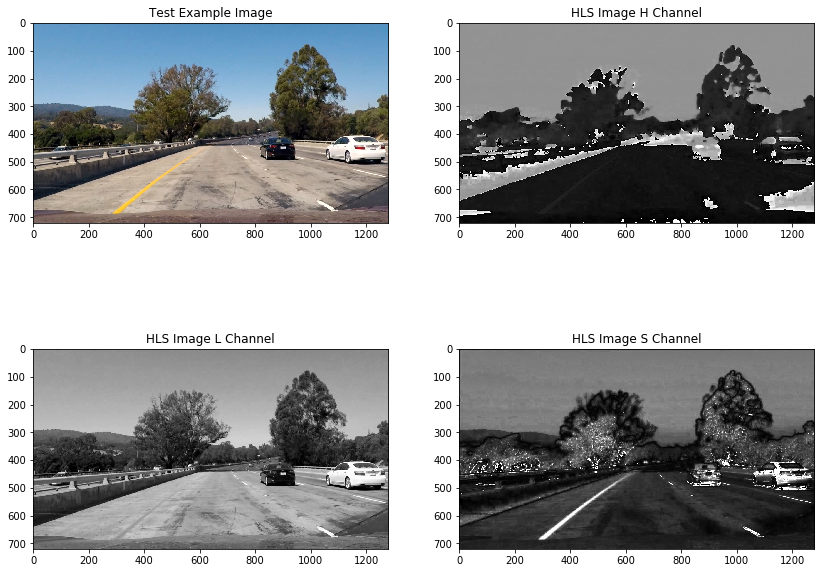

In [25]:
TestImage1 = mpimg.imread('./test_images/test1.jpg')
HLSImage = cv2.cvtColor(TestImage1, cv2.COLOR_RGB2HLS).astype(np.float)
HLSImageHChannel = HLSImage[:,:,0]
HLSImageLChannel = HLSImage[:,:,1]
HLSImageSChannel = HLSImage[:,:,2]
plotImages(2,2,(TestImage1, HLSImageHChannel,HLSImageLChannel, HLSImageSChannel),
           ("Test Example Image", "HLS Image H Channel", "HLS Image L Channel", "HLS Image S Channel"), 
           cmap='gray', FileName='HLSImages.png') 


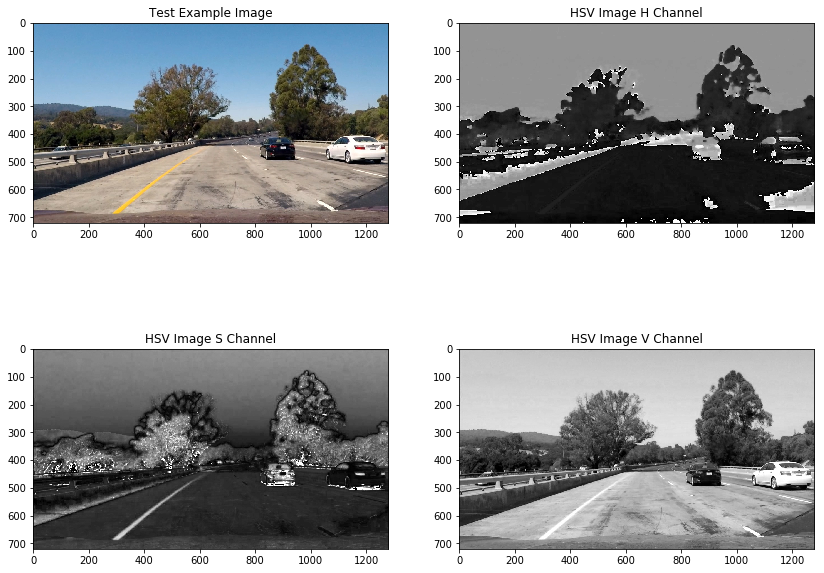

In [26]:
TestImage1 = mpimg.imread('./test_images/test1.jpg')
HSVImage = cv2.cvtColor(TestImage1, cv2.COLOR_RGB2HSV).astype(np.float)
HSVImageHChannel = HSVImage[:,:,0]
HSVImageSChannel = HSVImage[:,:,1]
HSVImageVChannel = HSVImage[:,:,2]

plotImages(2,2,(TestImage1, HSVImageHChannel,HSVImageSChannel, HSVImageVChannel),
           ("Test Example Image", "HSV Image H Channel", "HSV Image S Channel", "HSV Image V Channel"), 
           cmap='gray', FileName='HSVImages.png') 


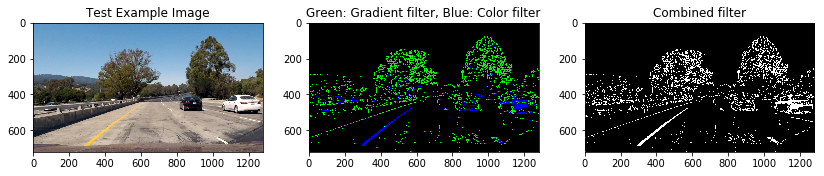

In [27]:
def ApplyGradColorFilters(img, SThreshold=(170, 255), SXThreshold=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    HLSImage = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    HLSImageLChannel = HLSImage[:,:,1]
    HLSImageSChannel = HLSImage[:,:,2]
    # Apply sobel x to L channel
    SobelX = cv2.Sobel(HLSImageLChannel, cv2.CV_64F, 1, 0) # Take the derivative in x
    AbsoluteSobelX = np.absolute(SobelX) # Absolute x derivative to accentuate lines away from horizontal
    ScaledSobel = np.uint8(255*AbsoluteSobelX/np.max(AbsoluteSobelX))
    
    # Threshold x gradient
    SXbinary = np.zeros_like(ScaledSobel)
    SXbinary[(ScaledSobel >= SXThreshold[0]) & (ScaledSobel <= SXThreshold[1])] = 1
    
    # Threshold color channel
    Sbinary = np.zeros_like(HLSImageSChannel)
    Sbinary[(HLSImageSChannel >= SThreshold[0]) & (HLSImageSChannel <= SThreshold[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    Colorbinary = np.dstack(( np.zeros_like(SXbinary), SXbinary, Sbinary))
    return Colorbinary

TestImage1 = mpimg.imread('./test_images/test1.jpg')
filters = ApplyGradColorFilters(TestImage1)
Combined = np.zeros_like(filters)
Combined[(filters[:,:,1] == 1) | (filters[:,:,2] == 1)] = 1
plotImages(1,3,(TestImage1, filters, Combined),
           ("Test Example Image", "Green: Gradient filter, Blue: Color filter", "Combined filter"), 
           cmap='gray', FileName='GradientGreenBlue.png') 

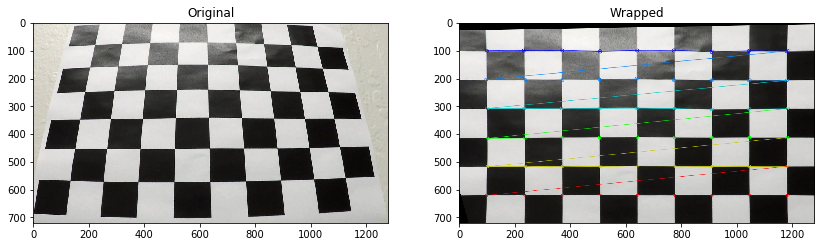

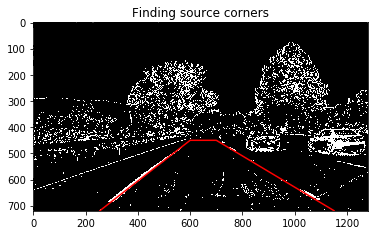

In [31]:
# Define a function that takes an image, number of x and y points, camera matrix and distortion coefficients
def CornersUnwarp(img, nx, ny, mtx, dist):
    # Args: mtx: camera matrix perfoms the task of removing distortion
    UndistortedImage = cv2.undistort(img, mtx, dist, None, mtx)
    GrayscaleImage = cv2.cvtColor(UndistortedImage, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(GrayscaleImage, (nx, ny), None)
    if ret == True:
        cv2.drawChessboardCorners(UndistortedImage, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (GrayscaleImage.shape[1], GrayscaleImage.shape[0])

        # For source points grab the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, choosing some points that will be a nice fit for displaying warped result 
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(UndistortedImage, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

CameraCalibrationImage = mpimg.imread('./camera_cal/calibration3.jpg')
warped, M, Minv = CornersUnwarp(CameraCalibrationImage, 9, 6, mtx, dist)
plotImages(1,2,(CameraCalibrationImage, warped),
           ("Original", "Wrapped"), cmap='gray', FileName='CornerWarpImage.png') 
plt.imsave('./Theoutput_images/SourecCorners.png',Combined, cmap='gray')
plt.imshow(Combined, cmap='gray')
plotted = plt.plot([255, 600, 700, 1150], [719, 450, 450, 719], 'r-')
plt.title('Finding source corners')

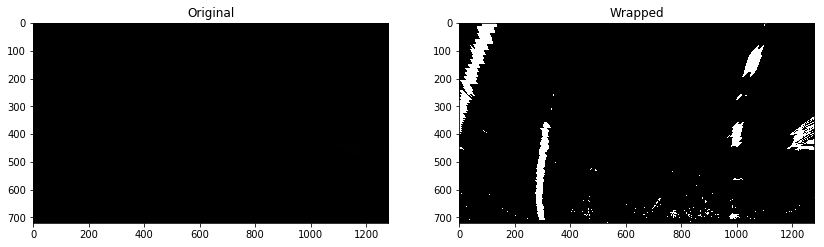

In [32]:
# perspective transformation
def TransformPerspective(img, SourceCorners):
    GrayscaleImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    OffsetX = 300 # offset for dst points
    OffsetY = 0
    # Grab the image shape
    ImageSize = (GrayscaleImage.shape[1], GrayscaleImage.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(SourceCorners)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([
        [OffsetX, OffsetY],  # top left
        [ImageSize[0] - OffsetX, OffsetY],  # top right 
        [ImageSize[0] - OffsetX, ImageSize[1] - OffsetY], # bottom right
        [OffsetX, ImageSize[1] - OffsetY]  # bottom left
    ])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Use this to revert transformation
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    WarpedImage = cv2.warpPerspective(GrayscaleImage, M, ImageSize)
    return WarpedImage, Minv

SourceCorners = [
    [600, 450],  # top left
    [700, 450],  # top right
    [1150, 719], # bottom right
    [255, 719]   # bottom left
]

WarpedImage, Minv = TransformPerspective(Combined.astype(np.uint8), SourceCorners)

plotImages(1,2,(Combined.astype(np.uint8), WarpedImage),
           ("Original", "Wrapped"), cmap='gray', FileName='TransformPresImage.png') 

In [45]:
def FindLanes(WrappedImage, visualize=False):
    # Assuming you have created a warped binary image called "WrappedImage"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(WrappedImage[int(WrappedImage.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    OutputImage= np.dstack((WrappedImage, WrappedImage, WrappedImage))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    Midpoint = np.int(histogram.shape[0]/2)
    LeftXBase = np.argmax(histogram[:Midpoint])
    RightXBase = np.argmax(histogram[Midpoint:]) + Midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    WindowsHeight = np.int(WrappedImage.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    NonZero = WrappedImage.nonzero()
    NonZeroY = np.array(NonZero[0])
    NonZeroX = np.array(NonZero[1])
    # Current positions to be updated for each window
    LeftXCurrent = LeftXBase
    RightXCurrent = RightXBase 
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    LeftLaneIndices = []
    RightLaneIndices = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        WindowYLow = WrappedImage.shape[0] - (window+1)*WindowsHeight
        WindowYHigh = WrappedImage.shape[0] - window*WindowsHeight
        WindowXLeftLow = LeftXCurrent - margin
        WindowXLeftHigh = LeftXCurrent + margin
        WindowXRightLow = RightXCurrent - margin
        WindowXRightHigh = RightXCurrent + margin
        # Draw the windows on the visualization image
        cv2.rectangle(OutputImage,(WindowXLeftLow,WindowYLow),(WindowXLeftHigh,WindowYHigh),(0,255,0), 2) 
        cv2.rectangle(OutputImage,(WindowXRightLow,WindowYLow),(WindowXRightHigh,WindowYHigh),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        GoodLeftIndices = ((NonZeroY >= WindowYLow) & (NonZeroY < WindowYHigh) & 
                           (NonZeroX >= WindowXLeftLow) & (NonZeroX < WindowXLeftHigh)).nonzero()[0]
        GoodRightIndices = ((NonZeroY >= WindowYLow) & (NonZeroY < WindowYHigh) & 
                            (NonZeroX >= WindowXRightLow) & (NonZeroX < WindowXRightHigh)).nonzero()[0]
        # Append these indices to the lists
        LeftLaneIndices.append(GoodLeftIndices)
        RightLaneIndices.append(GoodRightIndices)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(GoodLeftIndices) > minpix:
            LeftXCurrent = np.int(np.mean(NonZeroX[GoodLeftIndices]))
        if len(GoodRightIndices) > minpix:        
            RightXCurrent = np.int(np.mean(NonZeroX[GoodRightIndices]))

    # Concatenate the arrays of indices
    LeftLaneIndices = np.concatenate(LeftLaneIndices)
    RightLaneIndices = np.concatenate(RightLaneIndices)

    # Extract left and right line pixel positions
    LeftX = NonZeroX[LeftLaneIndices]
    LeftY = NonZeroY[LeftLaneIndices] 
    RightX = NonZeroX[RightLaneIndices]
    RightY = NonZeroY[RightLaneIndices] 

    # Fit a second order polynomial to each
    LeftFit = np.polyfit(LeftY, LeftX, 2)
    RightFit = np.polyfit(RightY, RightX, 2)
    
    # Generate x and y values for plotting
    PlotY = np.linspace(0, WrappedImage.shape[0]-1, WrappedImage.shape[0] )
    LeftFitX = LeftFit[0]*PlotY**2 + LeftFit[1]*PlotY + LeftFit[2]
    RightFitX = RightFit[0]*PlotY**2 + RightFit[1]*PlotY + RightFit[2]
    
    if visualize:
        OutputImage[NonZeroY[LeftLaneIndices], NonZeroX[LeftLaneIndices]] = [255, 0, 0]
        OutputImage[NonZeroY[RightLaneIndices], NonZeroX[RightLaneIndices]] = [0, 0, 255]
        plt.imsave('./Theoutput_images/FindLanes.png',OutputImage, cmap='gray')
        plt.imshow(OutputImage)
        plt.plot(LeftFitX, PlotY, color='yellow')
        plt.plot(RightFitX, PlotY, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('./Theoutput_images/FindLanes1.png')
    
    return LeftFitX, RightFitX, PlotY, LeftFit, RightFit

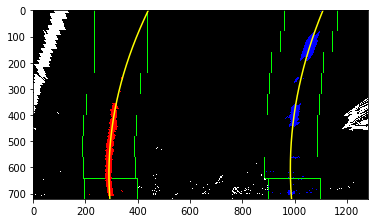

In [46]:
TheLeftFitX, TheRightFitX, ThePlotY, TheLeftFit, TheRightFit = FindLanes(WarpedImage, visualize=True)

In [50]:
def TheFindLanes(WrappedImage, LeftFit, RightFit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    NonZero = WrappedImage.nonzero()
    NonZeroY = np.array(NonZero[0])
    NonZeroX = np.array(NonZero[1])
    margin = 100
    LeftLaneIndices = ((NonZeroX > (LeftFit[0]*(NonZeroY**2) + LeftFit[1]*NonZeroY + LeftFit[2] - margin)) & (NonZeroX < (LeftFit[0]*(NonZeroY**2) + LeftFit[1]*NonZeroY + LeftFit[2] + margin))) 
    RightLaneIndices = ((NonZeroX > (RightFit[0]*(NonZeroY**2) + RightFit[1]*NonZeroY + RightFit[2] - margin)) & (NonZeroX < (RightFit[0]*(NonZeroY**2) + RightFit[1]*NonZeroY + RightFit[2] + margin)))  

    # Again, extract left and right line pixel positions
    LeftX = NonZeroX[LeftLaneIndices]
    LeftY = NonZeroY[LeftLaneIndices] 
    RightX = NonZeroX[RightLaneIndices]
    RightY = NonZeroY[RightLaneIndices]
    # Fit a second order polynomial to each
    TheLeftFit = np.polyfit(LeftY, LeftX, 2)
    TheRightFit = np.polyfit(RightY, RightX, 2)
    # Generate x and y values for plotting
    PlotY = np.linspace(0, WrappedImage.shape[0]-1, WrappedImage.shape[0] )
    LeftFitX = TheLeftFit[0]*PlotY**2 + TheLeftFit[1]*PlotY + TheLeftFit[2]
    RightFitX = TheRightFit[0]*PlotY**2 + TheRightFit[1]*PlotY + TheRightFit[2]

    # Create an image to draw on and an image to show the selection window
    OutPutImage = np.dstack((WrappedImage, WrappedImage, WrappedImage))*255
    WindowImage = np.zeros_like(OutPutImage)
    # Color in left and right line pixels
    OutPutImage[NonZeroY[LeftLaneIndices], NonZeroX[LeftLaneIndices]] = [255, 0, 0]
    OutPutImage[NonZeroY[RightLaneIndices], NonZeroX[RightLaneIndices]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    FirstLeftLineWindow = np.array([np.transpose(np.vstack([LeftFitX-margin, PlotY]))])
    SecondLeftLineWindow = np.array([np.flipud(np.transpose(np.vstack([LeftFitX+margin, PlotY])))])
    LeftLinePts = np.hstack((FirstLeftLineWindow, SecondLeftLineWindow))
    FirstrightLineWindow = np.array([np.transpose(np.vstack([RightFitX-margin, PlotY]))])
    SecondrightLineWindow = np.array([np.flipud(np.transpose(np.vstack([RightFitX+margin, PlotY])))])
    RightLinePts = np.hstack((FirstrightLineWindow, SecondrightLineWindow))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(WindowImage, np.int_([LeftLinePts]), (0,255, 0))
    cv2.fillPoly(WindowImage, np.int_([RightLinePts]), (0,255, 0))
    result = cv2.addWeighted(OutPutImage, 1, WindowImage, 0.3, 0)
    plt.imsave('./Theoutput_images/FindLanes2.png',result, cmap='gray')
    plt.imshow(result)
    plt.plot(LeftFitX, PlotY, color='yellow')
    plt.plot(RightFitX, PlotY, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('./Theoutput_images/FindLanes3.png')
    return LeftFitX, RightFitX, PlotY

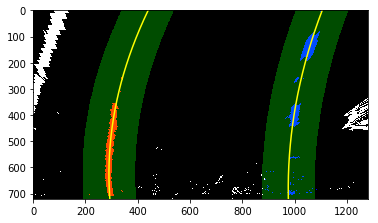

In [51]:
TheLeftFitX, TheRightFitX, ThePlotY = TheFindLanes(WarpedImage, TheLeftFit, TheRightFit)

In [52]:
def CalculateRadiusOfCurvature(LeftX, RightX, PlotY, XMPerPix=3.7/700, YMPerPix=30/720):
    #Calculate radius of curvature from pixels of left and right lanes in a image.
    #Args:
    #    LeftX, RightX, PlotY (arrays): points on the lane derived from the TheFindLanes 
    #    XMPerPix (float): Conversion in x from pixels space to merters
    #    YMPerPix (float): Conversion in y from pixels space to merters
    #Returns (float):
    #    Average of radius of left and right lane curvature in meters
    
    # Fit new polynomials to x,y in world space
    LeftFitCr = np.polyfit(PlotY*YMPerPix, LeftX*XMPerPix, 2)
    RightFitCr = np.polyfit(PlotY*YMPerPix, RightX*XMPerPix, 2)
    # Calculate the new radius of curvature
    LeftLaneCurverad = ((1 + (2*LeftFitCr[0]*PlotY*YMPerPix + LeftFitCr[1])**2)**1.5) / np.absolute(2*LeftFitCr[0])
    RightLaneCurverad = ((1 + (2*RightFitCr[0]*PlotY*YMPerPix + RightFitCr[1])**2)**1.5) / np.absolute(2*RightFitCr[0])
    # Now our radius of curvature is in meters
    return np.average([LeftLaneCurverad, RightLaneCurverad])

# show sample curvature
CalculateRadiusOfCurvature(TheLeftFitX, TheRightFitX, ThePlotY)

508.90670698934264

In [78]:
# Measuring offset from the center of the lane
def CalculateCenterOfTheLane(image, LeftFitX, RightFitX):
    # Define conversions in x and y from pixels space to meters
    XMPerPix = 3.7/700 # meters per pixel in x dimension
    Y = image.shape[0]
    TheLeftLane = LeftFitX[0]*Y**2 + LeftFitX[1]*Y + LeftFitX[2]
    TheRightLane = RightFitX[0]*Y**2 + RightFitX[1]*Y + RightFitX[2]
    TheCenterOfLane = TheRightLane + ((TheRightLane - TheRightLane) / 2)
    TheCenterOfCar = image.shape[1] / 2
    # offset in pixels
    TheOffsetInPixels = TheCenterOfLane - TheCenterOfCar
    # offset in meters
    TheOffsetInMeters = TheOffsetInPixels*XMPerPix
    # return the offset value
    return TheOffsetInMeters

# show Center
CalculateCenterOfTheLane(WarpedImage, TheLeftFit, TheRightFit)

1.8398873510391234

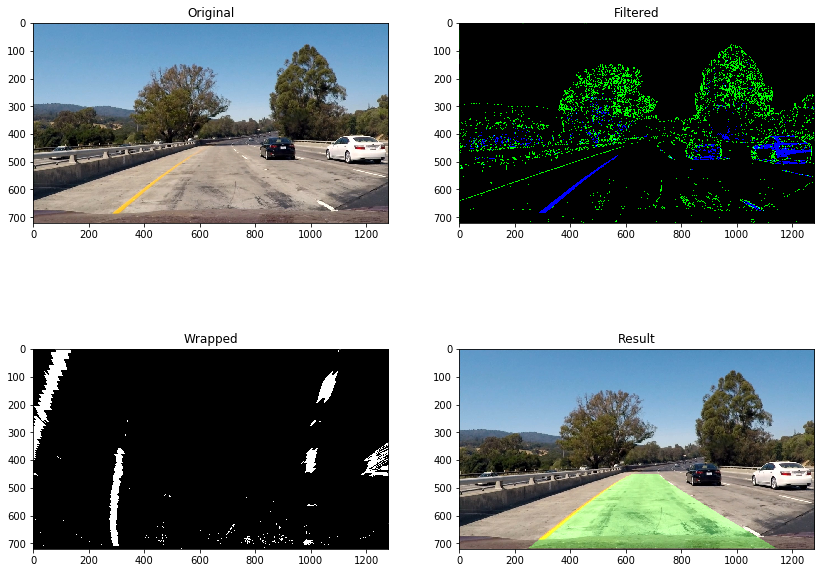

In [53]:
def ShowInsideLane(UnDistortedImage, WrappedImage, Minv, LeftFitX, RightFitX, PlotY):
    # Create an image to draw the lines on
    WarpZero = np.zeros_like(WrappedImage).astype(np.uint8)
    ColorWarp = np.dstack((WarpZero, WarpZero, WarpZero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    PtsLeft = np.array([np.transpose(np.vstack([LeftFitX, PlotY]))])
    PtsRight = np.array([np.flipud(np.transpose(np.vstack([RightFitX, PlotY])))])
    Pts = np.hstack((PtsLeft, PtsRight))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(ColorWarp, np.int_([Pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    NewWarp = cv2.warpPerspective(ColorWarp, Minv, (UnDistortedImage.shape[1], UnDistortedImage.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(UnDistortedImage, 1, NewWarp, 0.3, 0)  # image should be undistorted version
    return result

# show example
Testimage = mpimg.imread('./test_images/test1.jpg')
filters = ApplyGradColorFilters(Testimage)
corners = [
    [600, 450],  # top left
    [700, 450],  # top right
    [1150, 719], # bottom right
    [255, 719]   # bottom left
]
Combined = np.zeros_like(filters)
Combined[(filters[:,:,1] == 1) | (filters[:,:,2] == 1)] = 1
WrappedImage, Minv = TransformPerspective(Combined.astype(np.uint8), corners)
result = ShowInsideLane(Testimage, WrappedImage, Minv, TheLeftFitX, TheRightFitX, ThePlotY)

plotImages(2,2,(Testimage, filters, WarpedImage, result),("Original", "Filtered", "Wrapped", "Result"), 
           cmap='gray', FileName='FilteredWrappedAndFinal.png') 


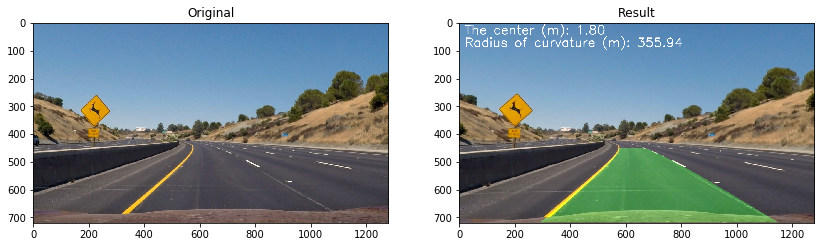

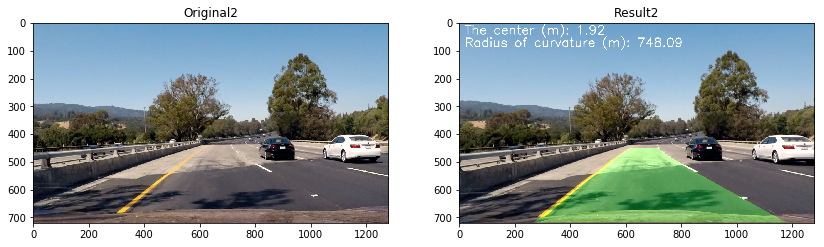

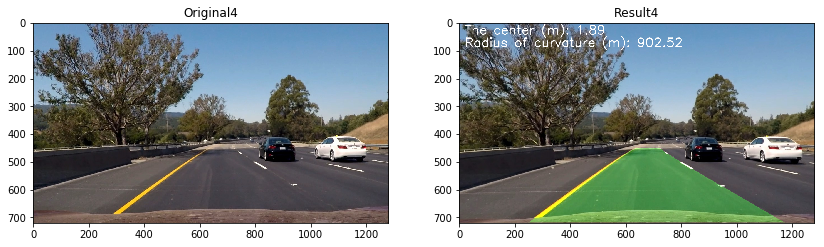

In [79]:
def AddDetectedLanes(img, mtx, dist, corners):
    # undistort image
    UndistortedImage = cv2.undistort(img, mtx, dist, None, mtx)
    # Apply gradient and color filters
    filters = ApplyGradColorFilters(img)
    Combined = np.zeros_like(filters)
    Combined[(filters[:,:,1] == 1) | (filters[:,:,2] == 1)] = 1
    # Transform perspective
    WrappedImage, Minv = TransformPerspective(Combined.astype(np.uint8), corners)
    # Find lanes
    ALeftFitX, ARightFitX, APlotY, ALeftFit, ARightFit = FindLanes(WrappedImage)
    # Draw predicted lane area
    TheResults = ShowInsideLane(UndistortedImage, WrappedImage, Minv, ALeftFitX, ARightFitX, APlotY)
    # show curvature
    CurvatureRadius = CalculateRadiusOfCurvature(ALeftFitX, ARightFitX, APlotY)
    cv2.putText(TheResults, 'Radius of curvature (m): {:.2f}'.format(CurvatureRadius),
                (20, 85), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    # show Center
    CenterOfRoad = CalculateCenterOfTheLane(img, ALeftFit, ARightFit)
    cv2.putText(TheResults, 'The center (m): {:.2f}'.format(CenterOfRoad),
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    return TheResults


Testimage = mpimg.imread('./test_images/test2.jpg')
corners = [
        [600, 450],  # top left
        [700, 450],  # top right
        [1150, 719], # bottom right
        [255, 719]   # bottom left
    ]
result = AddDetectedLanes(Testimage, mtx, dist, corners)

plotImages(2,2,(Testimage, result),("Original", "Result"), cmap='gray', FileName='OriginalAndResult.png') 

Testimage2 = mpimg.imread('./test_images/test4.jpg')
result2 = AddDetectedLanes(Testimage2, mtx, dist, corners)

plotImages(2,2,(Testimage2, result2),("Original2", "Result2"), cmap='gray', FileName='OriginalAndResult2.png') 

Testimage4 = mpimg.imread('./test_images/test6.jpg')
result4 = AddDetectedLanes(Testimage4, mtx, dist, corners)

plotImages(2,2,(Testimage4, result4),("Original4", "Result4"), cmap='gray', FileName='OriginalAndResult4.png') 

In [80]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def TransformImage(clip, mtx, dist, input_corners):
    # Helper function to apply lane detection.
    def _Transform(img):
        return AddDetectedLanes(img, mtx, dist, input_corners)
    return clip.fl_image(_Transform)

OutputFile = 'TestOutputVideo3.mp4'
clip1 = VideoFileClip("./project_video.mp4")

TestClip = clip1.fx(TransformImage, mtx, dist, corners)
%time TestClip.write_videofile(OutputFile, audio=False)

ChallengeOutputFile = 'TestOutputChallengeVideo.mp4'
clip2 = VideoFileClip("./challenge_video.mp4")

ChallengTestClip = clip2.fx(TransformImage, mtx, dist, corners)
%time ChallengTestClip.write_videofile(ChallengeOutputFile, audio=False)


[MoviePy] >>>> Building video TestOutputVideo3.mp4
[MoviePy] Writing video TestOutputVideo3.mp4


100%|█████████▉| 1260/1261 [05:51<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: TestOutputVideo3.mp4 

CPU times: user 5min 16s, sys: 1min 25s, total: 6min 42s
Wall time: 5min 53s
